# Разработка системы рекомендации стоимости автомобиля на основе его описания
### Нужно построить модель, которая будет определять стоимость автомобиля на основе его описания.
Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

В нашем распоряжении данные из файла: `autos.csv`.

## Импорт библеотек

In [1]:
## Для работы с данными:
# Для загрузки файлов(у меня):
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# Импортируем pandas как pd:
import pandas as pd
# Импортируем numpy как np:
import numpy as np
# Импорт метода для создания выборок:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

# Импортируем модели:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
# Импортируем градиентный бустинг:
!pip install lightgbm
import lightgbm
from lightgbm import LGBMRegressor

# Импортируем метрику:
from sklearn.metrics import mean_squared_error

# Импорт библиотеки для граффиков:
import plotly.express as ex
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/drive


## Подготовка данных

### Загружаем данные:

In [2]:
try:
  df = pd.read_csv('/datasets/autos.csv')
except:
  df = pd.read_csv("/content/drive/MyDrive/For_data/autos.csv")

In [3]:
# Создание функции для изучения данных:
def information(data):
    print('Общая информация о таблице:')
    print(data.info(), '\n')
    display(data.head(), '\n')
    print('Размер таблицы равен:', data.shape, '\n')
    print('Кол-во пропусков:', data.isna().sum(), '\n')
    print('Кол-во явных дубликатов:', data.duplicated().sum(), '\n')
    print('Статистические данные:')
    display(data.describe())

In [4]:
# Изучение информации о таблице:
information(df)
# Создание граффика корреляций:
ex.imshow(df.corr())

Общая информация о таблице:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  obje

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


'\n'

Размер таблицы равен: (354369, 16) 

Кол-во пропусков: DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64 

Кол-во явных дубликатов: 4 

Статистические данные:


,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<ipython-input-4-c117c299861e>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  ex.imshow(df.corr())


In [5]:
df.drop_duplicates(inplace=True)

Размер нашей таблицы: 354369 строк, 16 столбцов.
Признаки:
    
    DateCrawled — дата скачивания анкеты из базы.(неинформативно)
    
    VehicleType — тип автомобильного кузова.
    
    RegistrationYear — год регистрации автомобиля.
    
    Gearbox — тип коробки передач.
    
    Power — мощность (л. с.).
    
    Model — модель автомобиля.
    
    Kilometer — пробег (км).
    
    RegistrationMonth — месяц регистрации автомобиля.(неинформативно)
    
    FuelType — тип топлива.
    
    Brand — марка автомобиля.
    
    NotRepaired — была машина в ремонте или нет.
    
    DateCreated — дата создания анкеты.(неинформативно)
    
    NumberOfPictures — количество фотографий автомобиля.(неинформативно)
    
    PostalCode — почтовый индекс владельца анкеты (пользователя).(неинформативно)
    
    LastSeen — дата последней активности пользователя.(неинформативно)
Целевой признак:

    Price — цена (евро)

### Обработка выбросов:

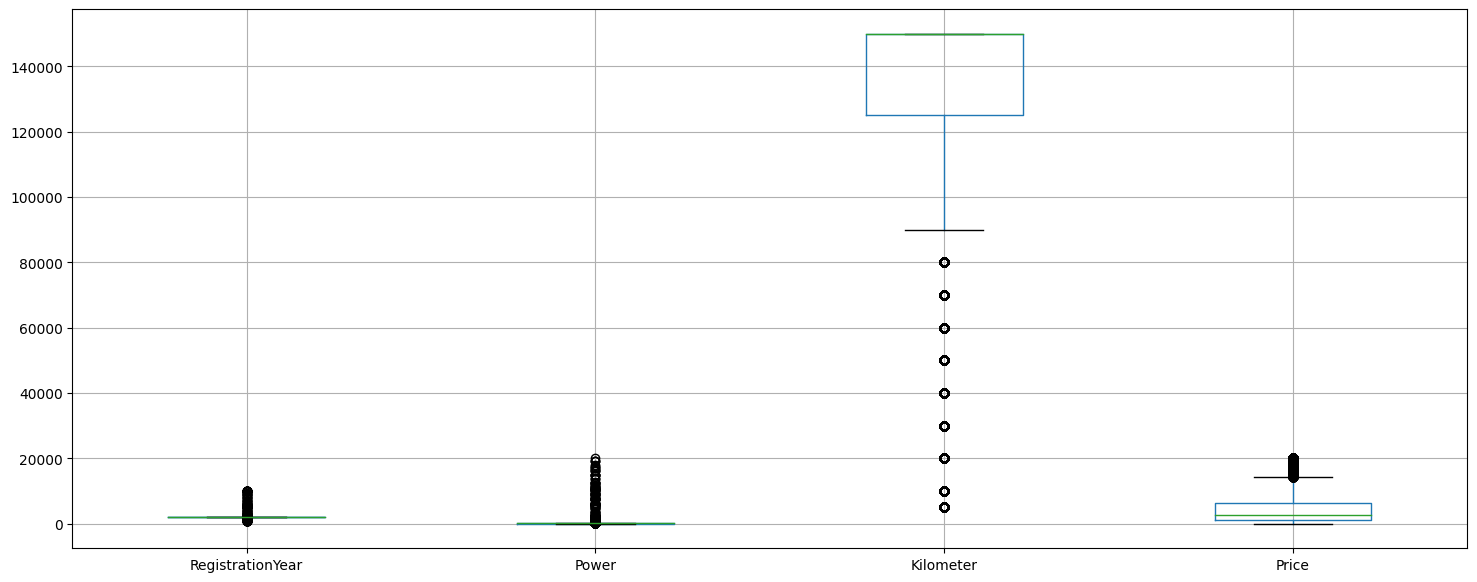

In [6]:
boxplot = df.boxplot(column=['RegistrationYear', 'Power', 'Kilometer', 'Price'], figsize=(18,7))
plt.show()

In [7]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,354365.0,354365.000000
mean,4416.679830,2004.234481,110.093816,128211.363989,5.714650,0.0,50508.503800
std,4514.176349,90.228466,189.851330,37905.083858,3.726432,0.0,25783.100078
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [9]:
# Удаление выбросов:
df = df.loc[df['Price'] > 10]
df = df.loc[(df['RegistrationYear'] > 1886) & (df['RegistrationYear'] < 2020)]

#### Вывод:
Выбросы решил удалить, по итогу ушло примерно 12 тысяч строк.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342122 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        342122 non-null  object
 1   Price              342122 non-null  int64 
 2   VehicleType        309051 non-null  object
 3   RegistrationYear   342122 non-null  int64 
 4   Gearbox            325325 non-null  object
 5   Power              342122 non-null  int64 
 6   Model              324943 non-null  object
 7   Kilometer          342122 non-null  int64 
 8   RegistrationMonth  342122 non-null  int64 
 9   FuelType           313279 non-null  object
 10  Brand              342122 non-null  object
 11  NotRepaired        277107 non-null  object
 12  DateCreated        342122 non-null  object
 13  NumberOfPictures   342122 non-null  int64 
 14  PostalCode         342122 non-null  int64 
 15  LastSeen           342122 non-null  object
dtypes: int64(7), object(

### Создание выборок:

In [11]:
# Создание переменной с целевым признаком:
target = df['Price']
# Создание переменной с признаками(особенностями):
features = df.drop(['DateCrawled', 'RegistrationMonth',
                      'Price', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)

<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Удалить неинформативные признаки - хорошее решение 👍
</div>

### Предобработка:

In [12]:
print('Кол-во пропусков в признаках:', features.isna().sum(), '\n')
print('Кол-во пропусков в цели:', target.isna().sum(), '\n')

Кол-во пропусков в признаках: VehicleType         33071
RegistrationYear        0
Gearbox             16797
Power                   0
Model               17179
Kilometer               0
FuelType            28843
Brand                   0
NotRepaired         65015
dtype: int64 

Кол-во пропусков в цели: 0 



In [13]:
features['VehicleType'] = features['VehicleType'].fillna('unknown')
features['Gearbox'] = features['Gearbox'].fillna('unknown')
features['Model'] = features['Model'].fillna('unknown')
features['FuelType'] = features['FuelType'].fillna('diesel')
features['NotRepaired'] = features['NotRepaired'].fillna('unknown')

In [14]:
display(features.head())
features.info()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown
1,coupe,2011,manual,190,unknown,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,unknown
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 342122 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   VehicleType       342122 non-null  object
 1   RegistrationYear  342122 non-null  int64 
 2   Gearbox           342122 non-null  object
 3   Power             342122 non-null  int64 
 4   Model             342122 non-null  object
 5   Kilometer         342122 non-null  int64 
 6   FuelType          342122 non-null  object
 7   Brand             342122 non-null  object
 8   NotRepaired       342122 non-null  object
dtypes: int64(3), object(6)
memory usage: 26.1+ MB


In [15]:
# Проверка:
print('Кол-во пропусков в признаках:', features.isna().sum(), '\n')

Кол-во пропусков в признаках: VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64 



#### Вывод:
Пропуски обработаны, всё замененно на 'неизвестно' ткк точно без обьявления картинок и тд мы сказать не можем. В типе топлива заменил на дизель, ткк это один из самых популярных видов топлива которого нет в таблице.

In [17]:
print('Кол-во явных дубликатов в признаках:', features.duplicated().sum(), '\n')
print('Кол-во явных дубликатов в цели:', target.duplicated().sum(), '\n')

Кол-во явных дубликатов в признаках: 176341 

Кол-во явных дубликатов в цели: 338401 



#### Вывод:
Мы видим, что есть большое кол-во дубликатов, Но это не они. Эти дубликаты появились из-за того, что на платформе есть просто похожие обьявления, но например с разной датой публикаций, другими картинками и т.д. Т.е. совсем другие обьявления, но из-за удаления некоторых признаков они появились.

### Порядковое преобразование:

In [16]:
columns_to_encode = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
encoder = OrdinalEncoder()
encoder.fit(features[columns_to_encode])
features[columns_to_encode] = encoder.transform(features[columns_to_encode])

### Разделение выборок:

In [18]:
# Разделение исходных данных на выборку для обучения 75%, и 25% для теста:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target, test_size=0.25, random_state=12345)

## Обучение моделей

### LightGBM:

In [19]:
%%time
params = {
    'num_leaves': [7, 14, 21, 28, 31, 50],
    'learning_rate': [0.5, 0.1, 0.05],
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500],
}
lgb = LGBMRegressor(metric='neg_root_mean_squared_error')
lgb_grid_clf = GridSearchCV(lgb, param_grid=params)
lgb_grid_clf.fit(features_train, target_train)
%time

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [20]:
%%time
lightgbmpredict = lgb_grid_clf.predict(features_test)
%time
lgb_result = mean_squared_error(target_test, lightgbmpredict, squared=False)
print('RMSE LightGBM:',lgb_result)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs
RMSE LightGBM: 1611.1589930690125
CPU times: user 3.01 s, sys: 6.94 ms, total: 3.02 s
Wall time: 3.1 s


### RandomForest:

In [ ]:
%%time
# Параметы для перебора:
parameters = {'n_estimators':range(1, 150),
            'max_depth':range(1,50)}
# Инициализация модели:
model_forest = RandomForestRegressor()
# Подбор гипперпараметров:
forest_grid_clf =  GridSearchCV(model_forest, parameters, scoring='neg_root_mean_squared_error')
%time
# Обучение модели:
forest_grid_clf.fit(features_train, target_train)
%time
# Вывод параметров:
print('Параметры модели:',forest_grid_clf.best_params_)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


In [ ]:
%%time
# Результат:
forest_grid_clf_predictions = forest_grid_clf.predict(features_test)
%time
forest_grid_clf_result = mean_squared_error(target_test, forest_grid_clf_predictions, squared=False)
print('RMSE Random Forest:',forest_grid_clf_result)

### Дерево решений:

In [ ]:
%%time
# Параметр для модели(перебор):
parameters = {'max_depth':range(1,21,1)}
# Инициализация модели:
model_tree = DecisionTreeRegressor(random_state=12345)
# Подбор гипперпараметров:
model_tree_grid_clf = GridSearchCV(model_tree, parameters, scoring='neg_root_mean_squared_error')
%time
# Обучение модели:
model_tree_grid_clf.fit(features_train, target_train)
%time
# Вывод параметров:
print('Параметры модели:',model_tree_grid_clf.best_params_)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs
CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs
Параметры модели: {'max_depth': 14}
CPU times: user 55.3 s, sys: 128 ms, total: 55.5 s
Wall time: 1min 1s


In [ ]:
%%time
# Результат:
model_tree_grid_clf_predictions = model_tree_grid_clf.predict(features_test)
%time
model_tree_grid_clf_result = mean_squared_error(target_test, model_tree_grid_clf_predictions, squared=False)
print('RMSE дерева решений:',model_tree_grid_clf_result)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs
RMSE дерева решений: 1942.4810456467492


## Анализ моделей


Самая лучшая и оптимальная в использовании: LightGBM. Время на её обучение составило 46 минут, предсказание идёт 2 секунды, со значением метрики RMSE 1611 - что являеется самым точным предсказанием среди всех моделей. Я советую использовать её, ткк Random Forest обучается больше 4 с половиной часов, значение метрики выдало , а у Дерева решений хоть и самое быстрое обучение с предсказанием (около минуты в сумме), самое низкая точность предсказания: RMSE 1942.

Лучшей моделью в данном проекте оказалось LightGBM. Ткк Работает она быстрее всех. Так же метрика RMSE ниже чем у дерева решений. Дольше всех загружался Random Forest. Поэтому в данной работе лучше всех LightGBM, ткк нам нужно качество и Скорость.

# Вывод:

# Лучшей моделью является - LightGBM.

## В данном проекте были предприняты следующие шаги:

### 1.) Полученна и анализирована общая информация о данных.

### 2.) Выполнена предобработка и подготовка данных.

### 3.) Проведена работа с разными моделями.

### 4.) Проанализирована скорость работы и её качество разных моделий.